# 02 — Target Data Preprocessing

This notebook constructs the **Target Index** for each state from 2015 to 2025 by merging
County Health Rankings (CHR) target metrics with FBI Hate Crime data.

In [2]:
import pandas as pd, numpy as np, os, json
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

DATA_DIR = "../data"
YEARS = range(2015, 2026)

# --- load annual CHR files and stack ---
frames = []
for y in YEARS:
    f = f"{DATA_DIR}/analytic_data{y}.csv"
    if os.path.exists(f):
        df_y = pd.read_csv(f)
        df_y["year"] = y
        frames.append(df_y)
chr_all = pd.concat(frames, ignore_index=True)

# --- hate-crime file ---
hate = pd.read_csv(f"{DATA_DIR}/hate_crime.csv")
hate.head()

,incident_id,data_year,ori,pug_agency_name,pub_agency_unit,agency_type_name,state_abbr,state_name,division_name,region_name,...,offender_race,offender_ethnicity,victim_count,offense_name,total_individual_victims,location_name,bias_desc,victim_types,multiple_offense,multiple_bias
0,43,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,Not Specified,1,Aggravated Assault,1.0,Residence/Home,Anti-Black or African American,Individual,S,S
1,44,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,Not Specified,2,Aggravated Assault;Destruction/Damage/Vandalis...,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,M,S
2,45,1991,AR0600300,North Little Rock,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,Not Specified,2,Aggravated Assault;Murder and Nonnegligent Man...,2.0,Residence/Home,Anti-White,Individual,M,S
3,46,1991,AR0600300,North Little Rock,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,Not Specified,1,Intimidation,1.0,Residence/Home,Anti-White,Individual,S,S
4,47,1991,AR0670000,Sevier,NaN,County,AR,Arkansas,West South Central,South,...,White,Not Specified,1,Intimidation,1.0,School/College,Anti-Black or African American,Individual,S,S


In [18]:
# --- Normalize target variables ---
target_cols = [
    # Health outcomes
    "v001_rawvalue",   # Premature death 
    "v127_rawvalue",   # Premature age-adjusted mortality 
    "v128_rawvalue",   # Child mortality 
    "v129_rawvalue",   # Infant mortality 
    "v135_rawvalue",   # Injury deaths 
    "v161_rawvalue",   # Suicides 
    "v015_rawvalue",   # Homicides 
    "v039_rawvalue",   # Motor vehicle crash deaths 
    "v148_rawvalue",   # Firearm fatalities 
    
    # Environmental / infrastructure factors
    "v125_rawvalue",   # Air pollution (PM2.5) 
    "v124_rawvalue",   # Drinking water violations 
    "v179_rawvalue",   # Access to parks 
    "v182_rawvalue",   # Adverse climate events 
    "v166_rawvalue",   # Broadband access 
    "v181_rawvalue",   # Library access 
    "v156_rawvalue",   # Traffic volume 
    
    # Behavioral / social outcomes
    "v134_rawvalue",   # Alcohol-impaired driving deaths 
    "v139_rawvalue",   # Food insecurity 
    "v083_rawvalue",   # Limited access to healthy foods 
    "v133_rawvalue",   # Food environment index 
    "v155_rawvalue"    # Flu vaccination 
]

scaler = MinMaxScaler()
# Aggregate to state level 
chr_state = chr_all.groupby("state", as_index=False).mean(numeric_only=True)

# Normalize selected columns
for col in target_cols:
    if col in chr_state:
        chr_state[f"{col}_norm"] = scaler.fit_transform(chr_state[[col]])


# --- Normalize hate crime then merge ---
hate_state = hate.groupby("state_abbr", as_index=False)["incident_id"].count()
hate_state["hate_crime_norm"] = scaler.fit_transform(hate_state[["incident_id"]])
merged = chr_state.merge(hate_state[["state_abbr","hate_crime_norm"]], left_on="state", right_on="state_abbr", how="left")

# Example output
merged[["state"] + [f"{col}_norm" for col in target_cols] + ["hate_crime_norm"]].head()

C:\Users\angel\AppData\Local\Temp\ipykernel_400\4043704959.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  chr_state = chr_all.groupby("state", as_index=False).mean(numeric_only=True)


,state,v001_rawvalue_norm,v127_rawvalue_norm,v128_rawvalue_norm,v129_rawvalue_norm,v135_rawvalue_norm,v161_rawvalue_norm,v015_rawvalue_norm,v039_rawvalue_norm,v148_rawvalue_norm,...,v182_rawvalue_norm,v166_rawvalue_norm,v181_rawvalue_norm,v156_rawvalue_norm,v134_rawvalue_norm,v139_rawvalue_norm,v083_rawvalue_norm,v133_rawvalue_norm,v155_rawvalue_norm,hate_crime_norm
0,AK,0.705505,0.469534,1.000000,0.518392,1.000000,1.000000,0.533665,0.293622,1.000000,...,0.089240,0.450630,1.000000,0.003493,1.000000,0.588651,0.877787,0.228491,0.000000,0.006628
1,AL,0.880711,0.883407,0.593327,0.717236,0.429432,0.324173,0.511567,0.833175,0.665514,...,0.479500,0.216602,0.248192,0.011906,0.343558,0.787326,0.397565,0.304658,0.391746,0.025058
2,AR,0.812751,0.831171,0.626557,0.703319,0.478020,0.431898,0.522992,0.775845,0.642272,...,0.419429,0.146893,0.193632,0.005630,0.261661,0.849774,0.552996,0.154695,0.488695,0.026215
3,AZ,0.658280,0.516476,0.405905,0.364227,0.668909,0.553333,0.311147,0.657539,0.567688,...,0.691612,0.468534,0.588495,0.059035,0.196622,0.682709,0.859485,0.129487,0.349580,0.173385
4,CA,0.222684,0.184003,0.138054,0.069587,0.253012,0.256848,0.216335,0.333524,0.290815,...,0.825087,0.893746,0.213962,0.220242,0.405016,0.462811,0.291270,0.679213,0.444689,1.000000


In [19]:
# --- Compute weighted composite score ---
total = 22 # total weights (21 + 1 for hate crime)
merged["target_index"] = 0

for col in target_cols:
    if f"{col}_norm" in merged:
        merged["target_index"] += merged[f"{col}_norm"]*(1/total)

merged["target_index"] += merged["hate_crime_norm"]*(1/total)

# Example output
merged[["state", "target_index"]].head()

,state,target_index
0,AK,0.560631
1,AL,0.459139
2,AR,0.473237
3,AZ,0.475925
4,CA,0.434599


In [21]:
# --- Classify into quintiles ---
merged["Percentile_Class"] = pd.qcut(merged["target_index"], q=5, labels=False) + 1
merged["Percentile_Continuous"] = merged["target_index"]

# Example output
merged[["state", "target_index", "Percentile_Class", "Percentile_Continuous"]].head()

,state,target_index,Percentile_Class,Percentile_Continuous
0,AK,0.560631,5.0,0.560631
1,AL,0.459139,4.0,0.459139
2,AR,0.473237,5.0,0.473237
3,AZ,0.475925,5.0,0.475925
4,CA,0.434599,4.0,0.434599


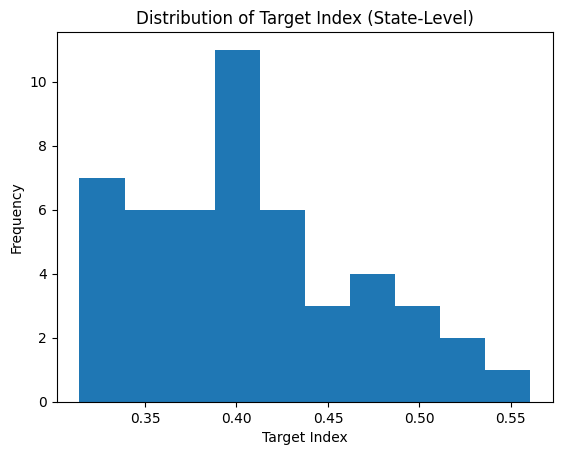

In [22]:
# --- Visualize target distribution ---
plt.hist(merged["target_index"], bins=10)
plt.title("Distribution of Target Index (State-Level)")
plt.xlabel("Target Index"); plt.ylabel("Frequency")
plt.show()

In [ ]:
# Optional Save Results
Path("../results/norm_targets").mkdir(parents=True, exist_ok=True)
merged.to_csv("../results/norm_targets/final_target_index_all_years.csv", index=False)
merged.to_json("../results/norm_targets/final_target_index_all_years.json", orient="records", indent=2)
merged.head()

,state,statecode,countycode,fipscode,year,county_ranked,v001_rawvalue,v001_numerator,v001_denominator,v001_cilow,...,v134_rawvalue_norm,v139_rawvalue_norm,v083_rawvalue_norm,v133_rawvalue_norm,v155_rawvalue_norm,state_abbr,hate_crime_norm,target_index,Percentile_Class,Percentile_Continuous
0,AK,2.0,143.658537,2143.658537,2020.082317,0.856574,10131.202337,669.036364,1.685030e+05,7738.561492,...,1.000000,0.588651,0.877787,0.228491,0.000000,AK,0.006628,0.560631,5.0,0.560631
1,AL,1.0,66.014706,1066.014706,2020.000000,1.000000,11265.332867,2459.836898,4.019964e+05,9879.954439,...,0.343558,0.787326,0.397565,0.304658,0.391746,AL,0.025058,0.459139,4.0,0.459139
2,AR,5.0,74.013158,5074.013158,2020.000000,1.000000,10825.418725,1286.784689,2.198646e+05,9089.289642,...,0.261661,0.849774,0.552996,0.154695,0.488695,AR,0.026215,0.473237,5.0,0.473237
3,AZ,4.0,13.000000,4013.000000,2020.000000,1.000000,9825.515272,10400.659091,2.430718e+06,9023.678484,...,0.196622,0.682709,0.859485,0.129487,0.349580,AZ,0.173385,0.475925,5.0,0.475925
4,CA,6.0,57.016949,6057.016949,2020.000000,0.992337,7005.848958,12174.243411,3.753684e+06,6242.990473,...,0.405016,0.462811,0.291270,0.679213,0.444689,CA,1.000000,0.434599,4.0,0.434599
